   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 23.5 MB/s eta 0:00:00
📥 Loading GoEmotions dataset...
Processing dataset...
Train size: 34919, Test size: 4414

🔤 MODEL 1: TF-IDF + Logistic Regression
TF-IDF feature shape: (34919, 5000)

📊 TF-IDF Results:
  Accuracy:  0.6309
  F1 Macro:  0.4244
  Precision: 0.7061
  Recall:    0.3706


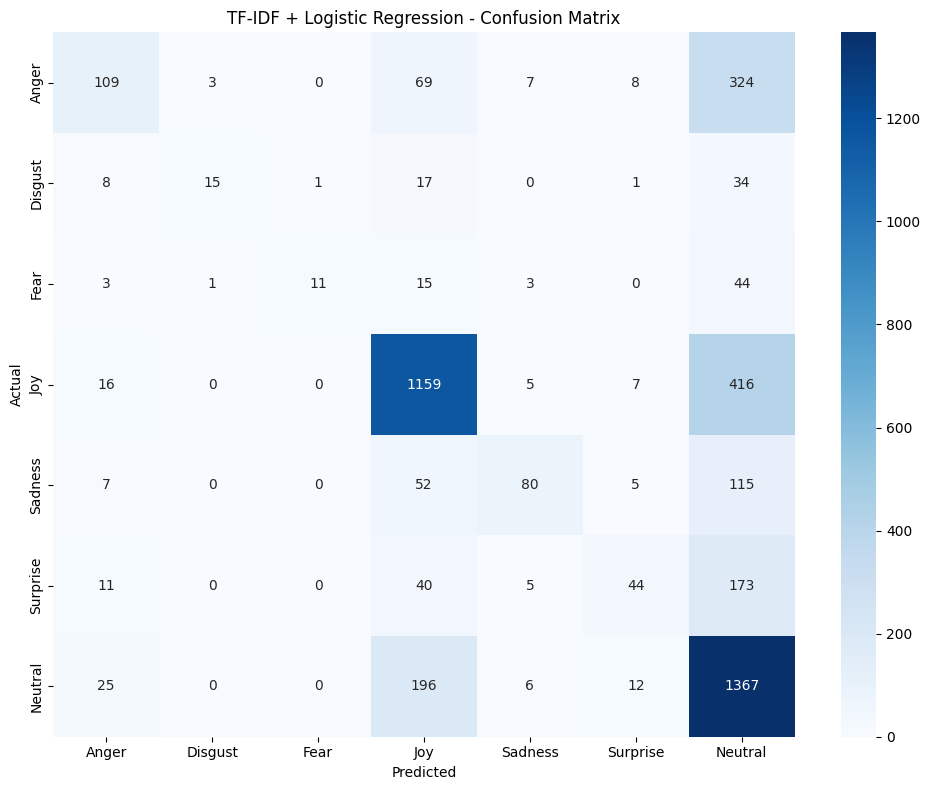


📋 Classification Report (TF-IDF):
              precision    recall  f1-score   support

       Anger     0.6089    0.2096    0.3119       520
     Disgust     0.7895    0.1974    0.3158        76
        Fear     0.9167    0.1429    0.2472        77
         Joy     0.7487    0.7230    0.7356      1603
     Sadness     0.7547    0.3089    0.4384       259
    Surprise     0.5714    0.1612    0.2514       273
     Neutral     0.5528    0.8512    0.6703      1606

    accuracy                         0.6309      4414
   macro avg     0.7061    0.3706    0.4244      4414
weighted avg     0.6540    0.6309    0.5988      4414


📐 MODEL 2: Word Embeddings + Logistic Regression
Loading GloVe embeddings (this may take a few minutes)...
[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe loaded!
Extracting embeddings for train set...
Extracting embeddings for test set...
Embedding feature shape: (34919, 100)

📊 Embedding Results:
  Accuracy:  0.5150
  F1

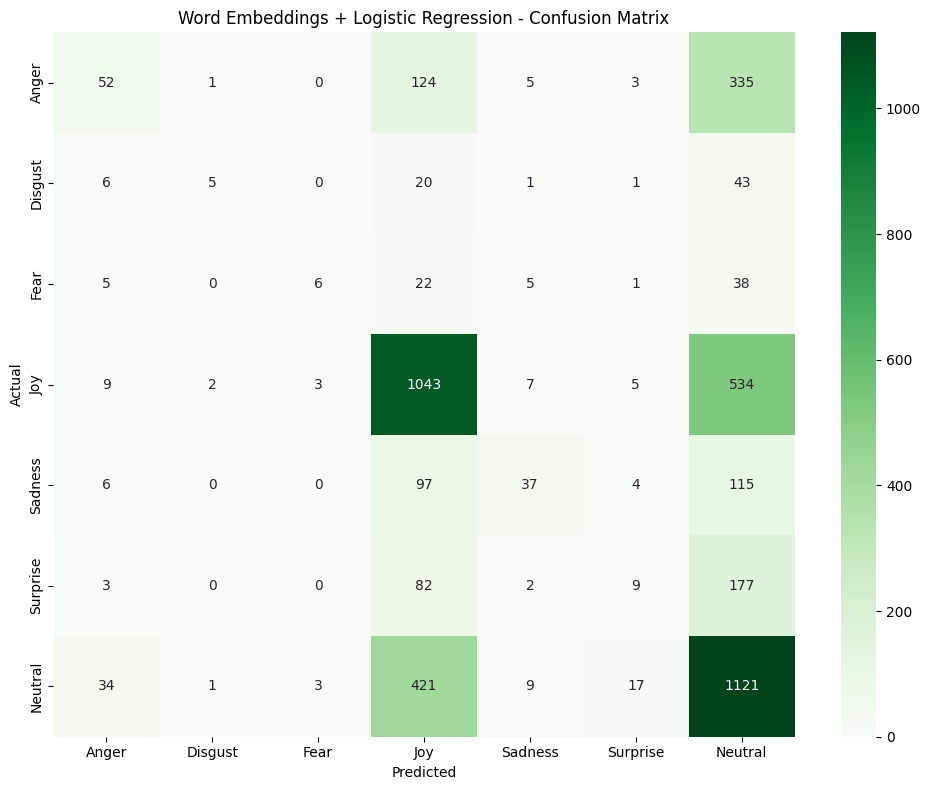


📋 Classification Report (Embeddings):
              precision    recall  f1-score   support

       Anger     0.4522    0.1000    0.1638       520
     Disgust     0.5556    0.0658    0.1176        76
        Fear     0.5000    0.0779    0.1348        77
         Joy     0.5766    0.6507    0.6114      1603
     Sadness     0.5606    0.1429    0.2277       259
    Surprise     0.2250    0.0330    0.0575       273
     Neutral     0.4744    0.6980    0.5649      1606

    accuracy                         0.5150      4414
   macro avg     0.4778    0.2526    0.2682      4414
weighted avg     0.5004    0.5150    0.4681      4414


📊 COMPARISON SUMMARY
              Model  Accuracy  F1 Macro  Precision   Recall
    TF-IDF + LogReg  0.630947  0.424363   0.706100 0.370585
Embeddings + LogReg  0.514952  0.268244   0.477756 0.252600


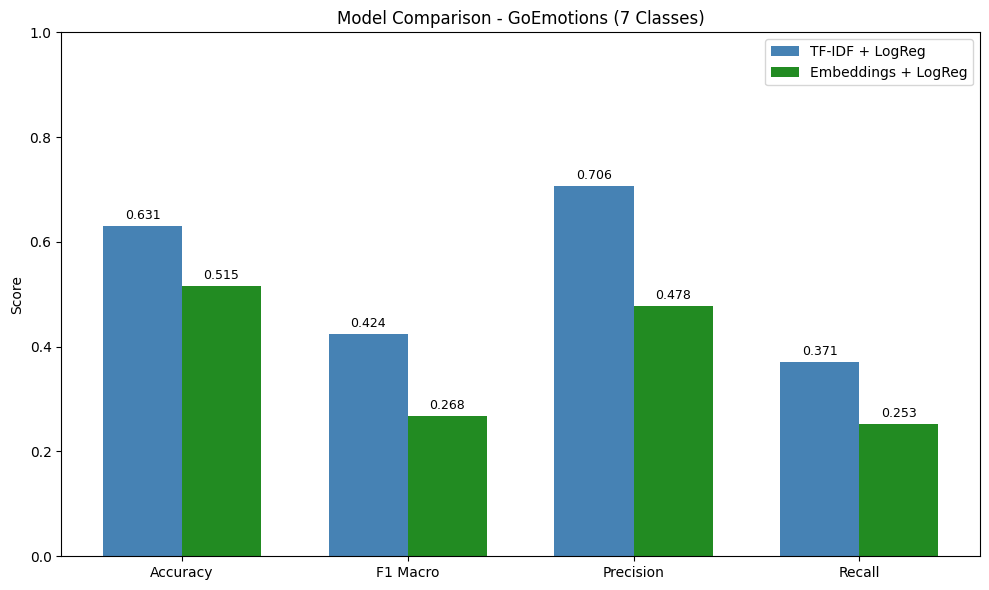


✅ Done! All results saved.


In [ ]:
# =========================
# 0. Setup
# =========================
!pip install -q datasets gensim scikit-learn pandas numpy matplotlib seaborn

import os
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. Load GoEmotions Dataset
# =========================
print("📥 Loading GoEmotions dataset...")
dataset = load_dataset("go_emotions")
label_names = dataset["train"].features["labels"].feature.names

# =========================
# 2. Map to 7 emotions
# =========================
label_map = {
    "anger": 0, "annoyance": 0, "disapproval": 0,
    "disgust": 1,
    "fear": 2, "nervousness": 2,
    "joy": 3, "amusement": 3, "approval": 3, "gratitude": 3,
    "love": 3, "optimism": 3, "pride": 3, "relief": 3,
    "admiration": 3, "desire": 3, "caring": 3, "excitement": 3,
    "sadness": 4, "disappointment": 4, "grief": 4,
    "remorse": 4, "embarrassment": 4,
    "surprise": 5, "realization": 5, "confusion": 5,
    "neutral": 6
}

emotion_names = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Neutral"]

def process_dataset(dataset_split):
    texts, labels = [], []
    for example in dataset_split:
        if len(example["labels"]) == 1:
            emotion = label_names[example["labels"][0]]
            if emotion in label_map:
                texts.append(example["text"])
                labels.append(label_map[emotion])
    return pd.Series(texts), pd.Series(labels)

# Process train and test
print("Processing dataset...")
train_texts, train_labels = process_dataset(dataset["train"])
test_texts, test_labels = process_dataset(dataset["test"])

print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")

# =========================
# 3. TF-IDF + Logistic Regression
# =========================
print("\n" + "="*50)
print("🔤 MODEL 1: TF-IDF + Logistic Regression")
print("="*50)

# TF-IDF Features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_texts)
X_test_tfidf = tfidf.transform(test_texts)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Train Logistic Regression
lr_tfidf = LogisticRegression(C=0.5, max_iter=1000, solver='lbfgs', random_state=42)
lr_tfidf.fit(X_train_tfidf, train_labels)

# Predict
preds_tfidf = lr_tfidf.predict(X_test_tfidf)

# Metrics
acc_tfidf = accuracy_score(test_labels, preds_tfidf)
prec_tfidf, rec_tfidf, f1_tfidf, _ = precision_recall_fscore_support(
    test_labels, preds_tfidf, average="macro", zero_division=0
)

print(f"\n📊 TF-IDF Results:")
print(f"  Accuracy:  {acc_tfidf:.4f}")
print(f"  F1 Macro:  {f1_tfidf:.4f}")
print(f"  Precision: {prec_tfidf:.4f}")
print(f"  Recall:    {rec_tfidf:.4f}")

# Confusion Matrix TF-IDF
cm_tfidf = confusion_matrix(test_labels, preds_tfidf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('TF-IDF + Logistic Regression - Confusion Matrix')
plt.tight_layout()
plt.savefig('cm_tfidf.png', dpi=150)
plt.show()

print("\n📋 Classification Report (TF-IDF):")
print(classification_report(test_labels, preds_tfidf, target_names=emotion_names, digits=4))

# =========================
# 4. Word Embeddings + Logistic Regression
# =========================
print("\n" + "="*50)
print("📐 MODEL 2: Word Embeddings + Logistic Regression")
print("="*50)

import gensim.downloader as api

print("Loading GloVe embeddings (this may take a few minutes)...")
glove = api.load('glove-wiki-gigaword-100')
print("GloVe loaded!")

def text_to_embedding(text, model, dim=100):
    """Convert text to average word embedding."""
    words = str(text).lower().split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(dim)

# Extract embedding features
print("Extracting embeddings for train set...")
X_train_emb = np.array([text_to_embedding(t, glove) for t in train_texts])
print("Extracting embeddings for test set...")
X_test_emb = np.array([text_to_embedding(t, glove) for t in test_texts])

print(f"Embedding feature shape: {X_train_emb.shape}")

# Train Logistic Regression
lr_emb = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs', random_state=42)
lr_emb.fit(X_train_emb, train_labels)

# Predict
preds_emb = lr_emb.predict(X_test_emb)

# Metrics
acc_emb = accuracy_score(test_labels, preds_emb)
prec_emb, rec_emb, f1_emb, _ = precision_recall_fscore_support(
    test_labels, preds_emb, average="macro", zero_division=0
)

print(f"\n📊 Embedding Results:")
print(f"  Accuracy:  {acc_emb:.4f}")
print(f"  F1 Macro:  {f1_emb:.4f}")
print(f"  Precision: {prec_emb:.4f}")
print(f"  Recall:    {rec_emb:.4f}")

# Confusion Matrix Embeddings
cm_emb = confusion_matrix(test_labels, preds_emb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_emb, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Word Embeddings + Logistic Regression - Confusion Matrix')
plt.tight_layout()
plt.savefig('cm_embeddings.png', dpi=150)
plt.show()

print("\n📋 Classification Report (Embeddings):")
print(classification_report(test_labels, preds_emb, target_names=emotion_names, digits=4))

# =========================
# 5. Comparison Summary
# =========================
print("\n" + "="*50)
print("📊 COMPARISON SUMMARY")
print("="*50)

comparison = pd.DataFrame({
    'Model': ['TF-IDF + LogReg', 'Embeddings + LogReg'],
    'Accuracy': [acc_tfidf, acc_emb],
    'F1 Macro': [f1_tfidf, f1_emb],
    'Precision': [prec_tfidf, prec_emb],
    'Recall': [rec_tfidf, rec_emb]
})
print(comparison.to_string(index=False))

# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(4)
width = 0.35

metrics = ['Accuracy', 'F1 Macro', 'Precision', 'Recall']
tfidf_scores = [acc_tfidf, f1_tfidf, prec_tfidf, rec_tfidf]
emb_scores = [acc_emb, f1_emb, prec_emb, rec_emb]

bars1 = ax.bar(x - width/2, tfidf_scores, width, label='TF-IDF + LogReg', color='steelblue')
bars2 = ax.bar(x + width/2, emb_scores, width, label='Embeddings + LogReg', color='forestgreen')

ax.set_ylabel('Score')
ax.set_title('Model Comparison - GoEmotions (7 Classes)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

print("\n✅ Done! All results saved.")